In [1]:
from func import *

import pickle as p
import glob 
import json
import subprocess
import getpass
import os
# import shutil

In [2]:
# ",".join(os.listdir('/home/abhijit/Jyotirmay/abdominal_segmentation/quickNAT_pytorch/create_datasets/datasets/lablmaps/KORA'))

In [3]:
dataset='KORA'
volume_txt_file = 'datasets/kora/volumes.txt'
data_dir = "/home/abhijit/nas_drive/Data_WholeBody/KORA/KORA_all/KORA_Nifti"
label_dir = 'datasets/lablmaps/KORA'

n4_corrected_data_dir = "temp/KORA/n4_corrected"
stictched_data_dir = "temp/KORA/stitched"
stitched_n4_corrected_data_dir = "temp/KORA/stitched_n4_corrected"

processed_path = 'temp/KORA/'
processed_dir = 'temp/KORA/processed'

one_time_n4_optimization = True

In [ ]:
# def rename_folder(dir_name,folder_id, prefix='KORA'):
#     create_if_not(f'{dir_name}/{prefix}{folder_id}')
#     os.rename(f'{dir_name}/{folder_id}/**', f'{dir_name}/{prefix}{folder_id}/**')

In [ ]:
# for folder_path in os.listdir('/home/abhijit/Jyotirmay/abdominal_segmentation/quickNAT_pytorch/create_datasets/datasets/lablmaps/KORA'):
#     dir_name = '/'.join(folder_path.split('/')[:-1])
#     folder_id = folder_path.split('/')[-1]
#     rename_folder(dir_name, folder_id)

In [4]:
def load_kora_file_paths(load_from_txt_file=True):
    volumes_to_use = []
    if load_from_txt_file:
        with open(volume_txt_file) as file_handle:
                volumes_to_use = file_handle.read().splitlines()
    else:
        volumes_to_use = [name for name in os.listdir(data_dir)]
    
    file_paths = {}
    
    for vol in volumes_to_use:
        if vol == "":
            continue
            
        labelmap_paths = glob.glob(f'{label_dir}/{vol}/**')
#         vol = 'KORA'+vol if dataset=='KORA' else vol
        opp_paths = glob.glob(f'{data_dir}/{vol}/**opp_[0-9]**.nii.gz')
        in_paths = glob.glob(f'{data_dir}/{vol}/**in_[0-9]**.nii.gz')
        f_paths = glob.glob(f'{data_dir}/{vol}/**F_[0-9]**.nii.gz')
        w_paths = glob.glob(f'{data_dir}/{vol}/**W_[0-9]**.nii.gz')
        
        vol_madals_paths = dict(
        OPP=opp_paths,
        IN=in_paths,
        F=f_paths,
        W=w_paths
        )
        file_paths[str(vol)]=dict(
            VOLUME_PATHS=vol_madals_paths,
            LABEL_PATHS=labelmap_paths,
        )
    return file_paths
        

In [ ]:
file_paths = load_kora_file_paths()

In [ ]:
 print(json.dumps(file_paths,sort_keys=True, indent=4))

In [ ]:
# Individual RESCALING.
n4_dict = {}
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    print(f'n4 processing part-1 started with {vol}...')
    n4_dict[vol] = []
    vol_parts = [[file, read_ras(file)] for file in file_paths[vol]['VOLUME_PATHS']['IN']]
    for orig_file, in_image in vol_parts:
        n4_dict[vol].append(rescale(in_image, vol, orig_file))

In [ ]:
# TODO: EXECUTE 'sudo sh ./n4-anne.sh' from command line for n4 bais field generation of all in imgs.

for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    print(f'applying n4 bias field on opp scans of {vol}...')
    vol_parts = [[read_ras(opp_file), read_ras(n4_counterpart['IN_BIAS']), opp_file] for opp_file, n4_counterpart in zip(file_paths[vol]['VOLUME_PATHS']['OPP'],n4_dict[vol])]
    idx = 0
    file_paths[vol]['N4_1'] = []
    for opp_img, bias_field_img, opp_file in vol_parts:
        file_paths[vol]['N4_1'].append(apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol][idx], vol))
        idx+=1
#         n4_dict[vol].append(rescale(opp_image, vol, n4_dict[vol]))



In [ ]:
# STITCHING VOL PARTS HERE
for vol in file_paths.keys():
    print(f'started with {vol}...')
    create_if_not(f'{n4_corrected_data_dir}/vol/{vol}')
    file_paths[vol]['ONE'] = {}
    for modality_key in file_paths[vol]['VOLUME_PATHS'].keys():
        print(f"processing {modality_key}")
        orig_modal_key = modality_key
        if one_time_n4_optimization:
            vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]
        else:
            if modality_key == 'OPP':
                vol_parts = [read_ras(data_dict['OPP_CORRECTED']) for data_dict in file_paths[vol]['N4_1']]
                modality_key = modality_key+'_n4_corrected'
            else:
                vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]

        ras_stitched = multi_vol_stitching(vol_parts)
        save_volume(ras_stitched, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched')
        file_paths[vol]['ONE'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched.nii.gz'

In [ ]:
# RESCALING INTENSITIES OF STITCHED VOLUME ABOVE 0
n4_dict = {}
for vol in file_paths.keys():
    print(f'n4 processing part-2 started with {vol}...')
    n4_dict[vol] = {}
    in_stitched_file_path, in_stitched_img = file_paths[vol]['ONE']['IN'], read_ras(file_paths[vol]['ONE']['IN'])
    n4_dict[vol]['N4_2'] = rescale(in_stitched_img, vol, in_stitched_file_path)

In [ ]:
# TODO: EXECUTE 'sudo sh ./n4-anne-2.sh' from command line for n4 bais field generation of all in imgs.
for vol in file_paths.keys():
    print(f'applying n4 bias field on stitched opp scans of {vol}...')

    opp_file = file_paths[vol]['ONE']['OPP']
    n4_counterpart = n4_dict[vol]['N4_2']
    print(opp_file, n4_counterpart['IN_BIAS'])
    opp_img = read_ras(opp_file)
    bias_field_img = read_ras(n4_counterpart['IN_BIAS'])

    file_paths[vol]['N4_2'] = apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol]['N4_2'], vol)

In [ ]:
with open('kora_file_paths.p', 'wb') as handle:
    p.dump(file_paths, handle, protocol=p.HIGHEST_PROTOCOL)

In [5]:
with open('kora_file_paths.p', 'rb') as handle:
    file_paths = p.load(handle)

In [6]:
def vol_label_fix(vol, label):
    vol_vol = np.product(vol.shape)
    label_vol = np.product(label.shape)
    
    world_shape = np.max(np.array([list(vol.shape), list(label.shape)]), axis=0)
    print(tuple(world_shape))
    final_label = np.zeros(tuple(world_shape))
    label_affine = label.affine
    vol_affine = vol.affine
    if(vol_vol>label_vol):
#         final_label = np.zeros(vol.shape)
        target_affine = vol_affine
        target_header = vol.header
        target_dim_v = vol.shape
        
#         labelmap2vol = npl.inv(target_affine).dot(label_affine)
#         start_inv = np.floor(apply_affine(labelmap2vol, [0,0,0])).astype(np.int32)
#         sx, sy,sz = start_inv
#         end_inv = apply_affine(labelmap2vol, target_dim_v).astype(np.int32)
#         final_label = np.zeros(end_inv)
#         ex, ey, ez = end_inv
#         print("seg start inv v: ",start_inv , "segm end inv v:",end_inv)
        sx,sy,sz,ex,ey,ez = np.abs(get_points(label, vol))
        print(sx,sy,sz,ex,ey,ez)
        final_label[0:ex+sx, 0:ey+sy, 0:ez+sz] = label.get_fdata()
        final_label = np.flip(final_label, axis=0)
#         final_label = np.flip(final_label, axis=1)
        final_label = np.flip(final_label, axis=2)
        final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
        volume, label = vol, final_label_img
    else:
#         final_label = np.zeros(label.shape)
        target_affine = label_affine
        target_header = label.header
        target_dim_v = label.shape
        
#         labelmap2vol = npl.inv(target_affine).dot(vol_affine)
#         start_inv = np.floor(apply_affine(labelmap2vol, [0,0,0])).astype(np.int32)
#         sx, sy,sz = start_inv
#         end_inv = apply_affine(labelmap2vol, target_dim_v).astype(np.int32)
#         final_label = np.zeros(end_inv)
#         ex, ey, ez = end_inv
#         print("seg start inv v: ",start_inv , "segm end inv v:",end_inv)
        sx,sy,sz,ex,ey,ez = np.abs(get_points(vol, label))
        print(sx,sy,sz,ex,ey,ez)
        final_label = np.flip(final_label, axis=0)
#         final_label = np.flip(final_label, axis=1)
        final_label = np.flip(final_label, axis=2)
        final_label[0:ex+sx, 0:ey+sy, 0:ez+sz] = vol.get_fdata()
        
        final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
        volume, label = final_label_img, label
    
    return volume, label

STARTING KORA LABEL-MAPS.
Reading Label Maps.....
KORA2456289
['datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-22.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (Right).nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (Left).nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-5.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-22.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2456289/2456289_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to 

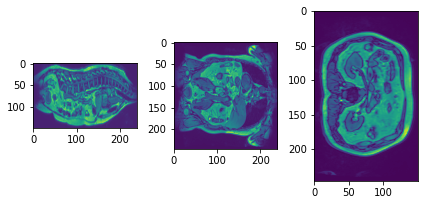

Affine:[[   2.            0.            0.         -253.02911377]
 [   0.            2.            0.         -152.5677948 ]
 [   0.            0.            3.         -734.99206543]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


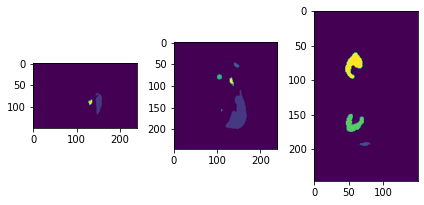

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2459728
['datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8Kidney (Left).nrrd', 'datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-6.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2459728/2459728_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (Right).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(288, 160, 288)
After 3d 

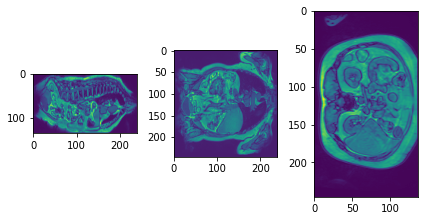

Affine:[[   2.            0.            0.         -228.67341614]
 [   0.            2.            0.         -146.25567627]
 [   0.            0.            3.         -802.67254639]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


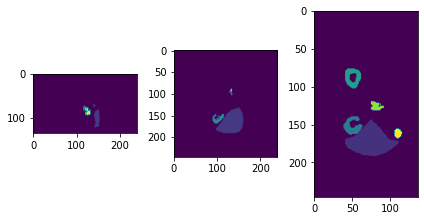

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2452879
['datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-2_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2452879/Combi', 'datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-2_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-2_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-2_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-2_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-2_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-2_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2452879/2452879_t1_vibe_dixon_cor_caip

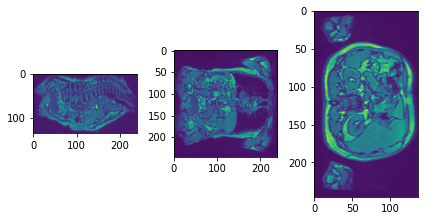

Affine:[[   2.            0.            0.         -243.27729797]
 [   0.            2.            0.         -151.14399719]
 [   0.            0.            3.         -693.54003906]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


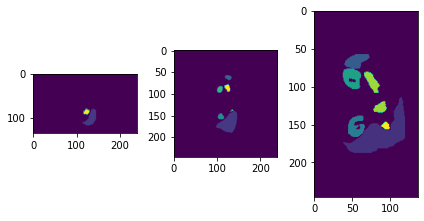

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2453578
['datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20.nii_Liver-2.nrrd', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2453578/Combi', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2453578/2453578_t1_

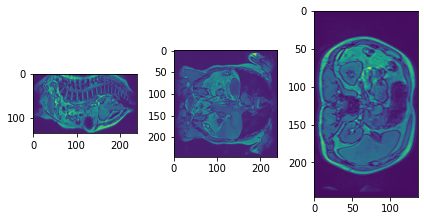

Affine:[[   2.            0.            0.         -248.14639282]
 [   0.            2.            0.         -141.38415527]
 [   0.            0.            3.         -759.14685059]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


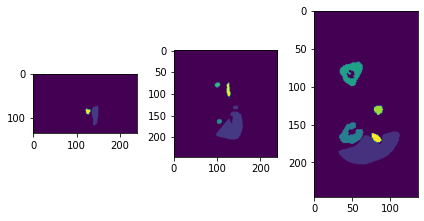

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2459908
['datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Liver-2.nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Kidney (right) .nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2459908/2459908_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3_Kidney (left)

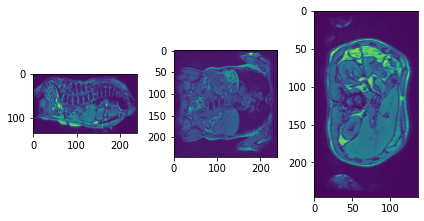

Affine:[[   2.            0.            0.         -243.3011322 ]
 [   0.            2.            0.         -163.25665283]
 [   0.            0.            3.         -729.90161133]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


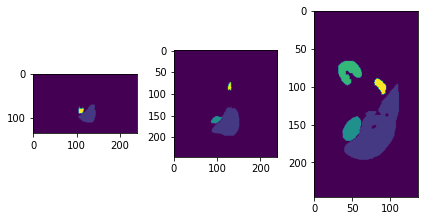

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2453229
['datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-14 (1)_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-14 (1)_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-14 (1)_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2453229/2453229_t1_vibe_dixon_cor_caipi6_bh_288_is

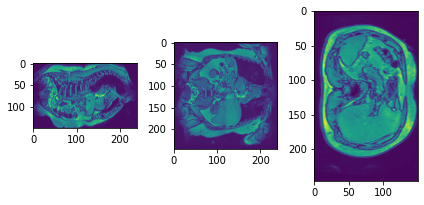

Affine:[[   2.            0.            0.         -226.26609802]
 [   0.            2.            0.         -145.30841064]
 [   0.            0.            3.         -712.81213379]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


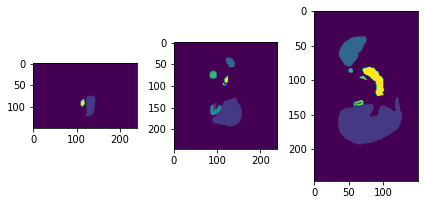

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2456120
['datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2456120/Combi', 'datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (Left).nrrd', 'datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-3.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-21.nrrd_Adrenal galnd(right).nrrd', 'datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-21.nrrd_adrenal gland (left).nrrd', 'datasets/lablmaps/KORA/KORA2456120/2456120_t1_vibe

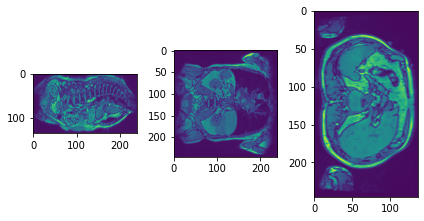

Affine:[[   2.            0.            0.         -250.58435059]
 [   0.            2.            0.         -148.65837097]
 [   0.            0.            3.         -739.35723877]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


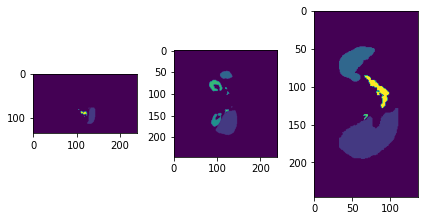

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2453290
['datasets/lablmaps/KORA/KORA2453290/2453290_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2453290/2453290_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2453290/2453290_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Liver-2.nrrd', 'datasets/lablmaps/KORA/KORA2453290/2453290_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2453290/2453290_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2453290/2453290_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2453290/2453290_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-13_Pancreas.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(288, 160, 288)
Af

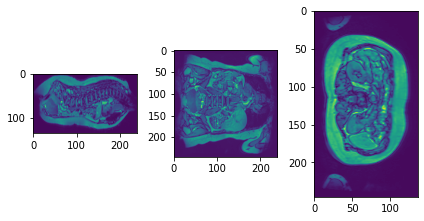

Affine:[[   2.            0.            0.         -243.28752136]
 [   0.            2.            0.         -153.54449463]
 [   0.            0.            3.         -761.46221924]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


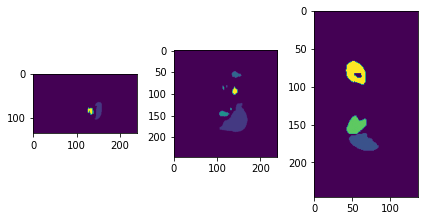

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2460734
['datasets/lablmaps/KORA/KORA2460734/2460734_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2460734/2460734_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2460734/2460734_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2460734/2460734_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-4.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2460734/2460734_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2460734/2460734_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-7_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2460734/2460734t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2460734/2460734_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-7.nrrd_Adrenal gland(right).nrr

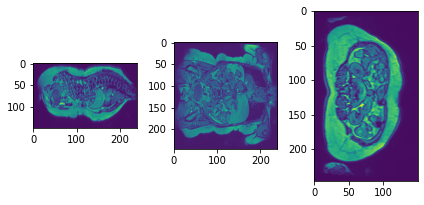

Affine:[[   2.            0.            0.         -245.71525574]
 [   0.            2.            0.         -157.43348694]
 [   0.            0.            3.         -722.87719727]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


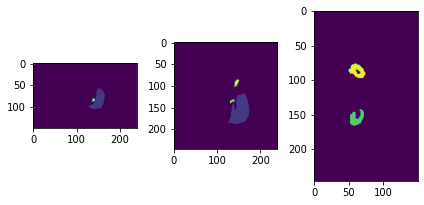

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2460830
['datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_10_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9.nii_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2460830/2460830_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9-4.nrrd_Adrenal gland(left).n

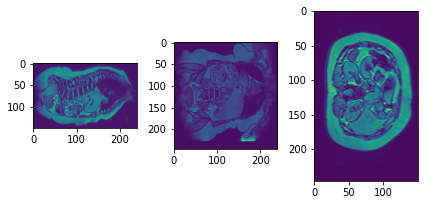

Affine:[[   2.            0.            0.         -204.32450867]
 [   0.            2.            0.         -162.29162598]
 [   0.            0.            3.         -712.89044189]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


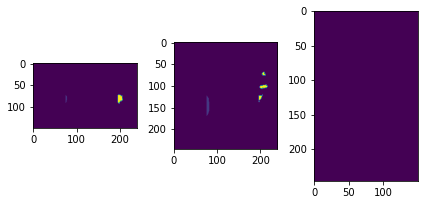

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2459745
['datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-24.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-24.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-20.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2459745/2459745_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8

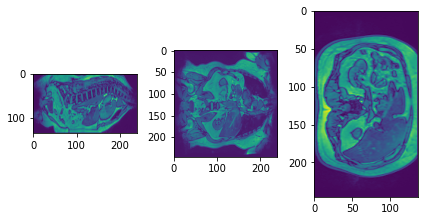

Affine:[[   2.            0.            0.         -238.42182922]
 [   0.            2.            0.         -131.72450256]
 [   0.            0.            3.         -727.28662109]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


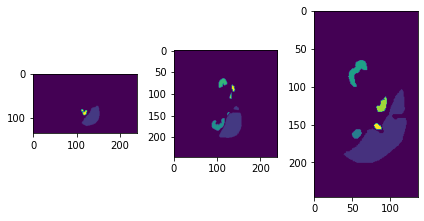

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2460408
['datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Kidney(left).nrrd', 'datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2460408/2460408_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Kidney(right).nrrd']
Readi

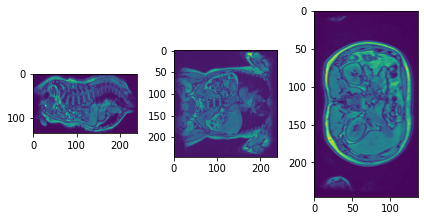

Affine:[[   2.            0.            0.         -243.29772949]
 [   0.            2.            0.         -153.51043701]
 [   0.            0.            3.         -768.49346924]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


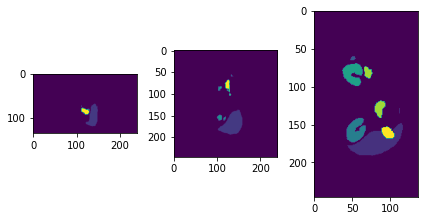

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2458366
['datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-18.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-23.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-23.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (Left).nrrd', 'datasets/lablmaps/KORA/KORA2458366/2458366_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (R

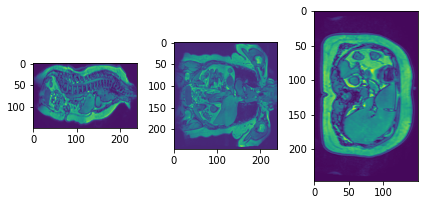

Affine:[[   2.            0.            0.         -243.28070068]
 [   0.            2.            0.         -152.59162903]
 [   0.            0.            3.         -678.91912842]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 150, 239)


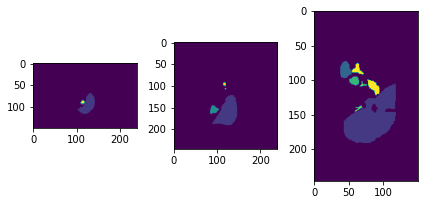

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2462405
['datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Kidney (right).nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2462405/2462405_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Spleen.nrrd']
Rea

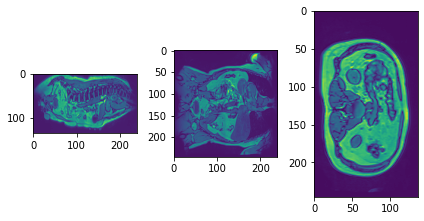

Affine:[[   2.            0.            0.         -248.14639282]
 [   0.            2.            0.         -148.68902588]
 [   0.            0.            3.         -719.81274414]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


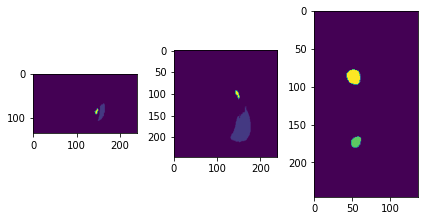

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2460723
['datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-25.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8-26.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (left).nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nii_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2460723/2460723_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney(

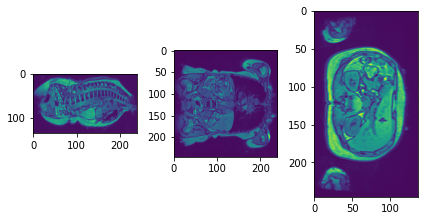

Affine:[[   2.            0.            0.         -253.04954529]
 [   0.            2.            0.         -160.82771301]
 [   0.            0.            3.         -681.3638916 ]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


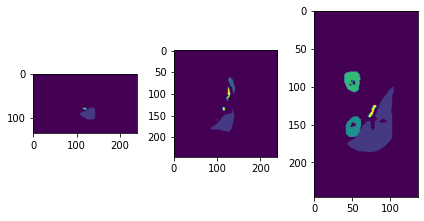

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2460249
['datasets/lablmaps/KORA/KORA2460249/2460249_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2460249/2460249_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2460249/2460249_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2460249/2460249_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Kidney(left).nrrd', 'datasets/lablmaps/KORA/KORA2460249/2460249_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Adrenal gland(left).nrrd', 'datasets/lablmaps/KORA/KORA2460249/2460249_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Kidney(right).nrrd', 'datasets/lablmaps/KORA/KORA2460249/2460249_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2460249/2460249_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_9_Gallbladder.nrrd']
Reading Files

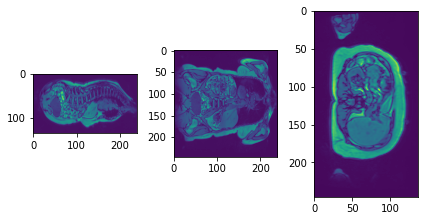

Affine:[[   2.            0.            0.         -221.36976624]
 [   0.            2.            0.         -172.96640015]
 [   0.            0.            3.         -688.6572876 ]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


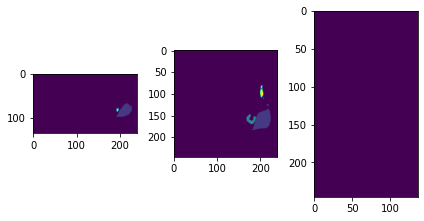

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2453666
['datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20.nii_Kidney (right)-4.nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Adrenal gland(right).nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20.nii_Kidney (left)-3.nrrd', 'datasets/lablmaps/KORA/KORA2453666/2453666_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Adrenal gland(left

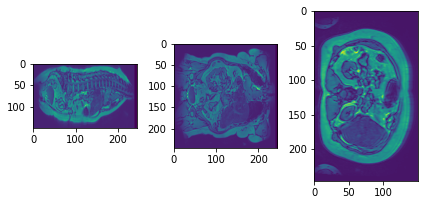

Affine:[[   2.            0.            0.         -240.15220642]
 [   0.            2.            0.         -444.74897575]
 [   0.            0.            3.          -11.6140852 ]
 [   0.            0.            0.            1.        ]], Image Shape: (245, 148, 245)


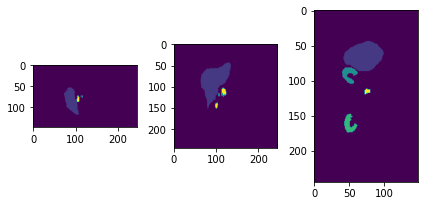

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2462026
['datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Liver.nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Kidney (left)-2.nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13.nii_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13.nii_Gallbladder.nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13.nii_Adrenal gland (right).nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13.nii_Adrenal gland (left).nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_13_Kidney (right)-3.nrrd', 'datasets/lablmaps/KORA/KORA2462026/2462026_t1_vibe_dixon_cor_caipi6_bh_288_iso_op

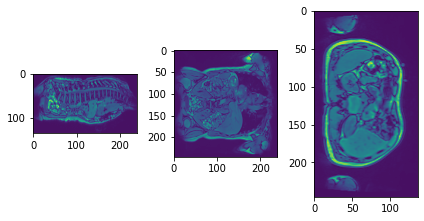

Affine:[[   2.            0.            0.         -245.71185303]
 [   0.            2.            0.         -155.94158936]
 [   0.            0.            3.         -729.93225098]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


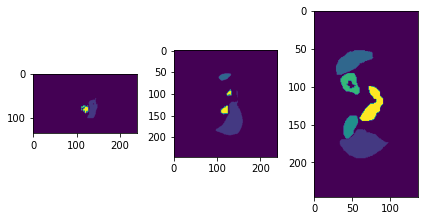

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
KORA2453363
['datasets/lablmaps/KORA/KORA2453363/2453363_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (Right).nrrd', 'datasets/lablmaps/KORA/KORA2453363/Combi', 'datasets/lablmaps/KORA/KORA2453363/2453363_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Kidney (Left).nrrd', 'datasets/lablmaps/KORA/KORA2453363/2453363_t1_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8_Gallbladder-2.nrrd', 'datasets/lablmaps/KORA/KORA2453363/2453363_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nrrd_Pancreas.nrrd', 'datasets/lablmaps/KORA/KORA2453363/2453363_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/KORA/KORA2453363/2453363_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_8.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/KORA/KORA2453363/2453363_t1_vibe_dixon_cor_caipi6_bh_288_iso_opp_20_Spleen.nrrd', 'datasets/lablmaps/KORA/KORA2453363/2453363

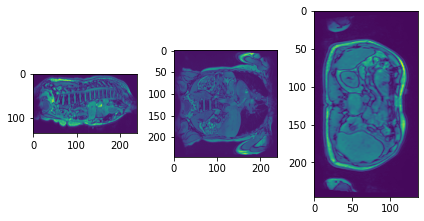

Affine:[[   2.            0.            0.         -253.53926086]
 [   0.            2.            0.         -156.88252258]
 [   0.            0.            3.         -819.75115967]
 [   0.            0.            0.            1.        ]], Image Shape: (246, 137, 239)


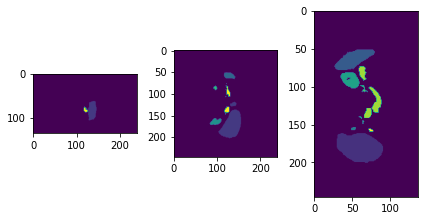

Saving Processed & Stitched Image.....
saving directory: temp/KORA/processed/volume
saving directory: temp/KORA/processed/label
FINISHED.


In [35]:
print("STARTING KORA LABEL-MAPS.")
print('Reading Label Maps.....')
for vol in file_paths.keys():
    print(vol)
#     if vol not in ['KORA2456289', 'KORA2452879']:
#         continue
    later = None
    print(file_paths[vol]['LABEL_PATHS'])
    if len(file_paths[vol]['LABEL_PATHS']) == 0:
        print(f"#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR {vol} #########################")
        continue
    volume = nb.load(file_paths[vol]['N4_2']['OPP_CORRECTED'])
    img_ras_list = []
    for label_file_to_read in file_paths[vol]['LABEL_PATHS']:
        img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
        if img_ras is None:
            continue
        print(img_ras.shape)
        img_ras = makeit_3d(img_ras)
        print('After 3d confirmed:', img_ras.shape)
        mode='constant'
        img_ras = resample_to_output(img_ras, TARGET_RESOLUTION, order=3, mode=mode, cval=0.0)
    #     img_ras = resample_from_to(img_ras, [volume.shape, img_ras.affine])
        if labelname == 'SPLEEN':
            later = [img_ras, lidx, labelname]
        else:
            img_ras_list.append([img_ras, lidx, labelname])
    if later is not None:
        img_ras_list.append(later)
    
    s_label = label_parts(img_ras_list)
    volume, s_label = vol_label_fix(volume, s_label)
    #     volume, stitched_label = combine_nako_seg(file_paths[vol]['LABEL_PATHS'],'' ,file_paths[vol]['N4_2']['OPP_CORRECTED'])

    print('Viewing Stitched Images.....')
    volume_3_view_viewer(get_volume_data(volume))
    volume_3_view_viewer(get_volume_data(s_label))

    print('Saving Processed & Stitched Image.....')
    save_volume(volume, f'{processed_dir}/volume/{vol}')
    save_volume(s_label, f'{processed_dir}/label/{vol}')
    
print('FINISHED.')

In [78]:
def crop_roi(paths):
    affine = None
    data = np.zeros((256,256,400))
    for path in paths:
        print(path)
        img = nb.load(path)
        if affine is None:
            affine = img.affine
#         img = resample_from_to(img, [(300, 300, 300), img.affine])
        img_data= img.get_fdata()
        x,y,z = img.shape
        print(x,y,z)
        data[:x, :y, :z] += img_data
        
    empty_header = nibabel.Nifti1Header()
    all_label_img = nb.Nifti1Image(data, affine, empty_header)
    return all_label_img

def remove_black(labelmap):
    clean_labels = []
    start, end = None, None
    for i, frame in enumerate(labelmap):
        unique, counts = np.unique(frame, return_counts=True)
        if counts[0] / sum(counts) < .99:
            clean_labels.append(frame)
            if start is None:
                start = i
            end = None
        if end is None:
            end = i
    if end is None:
        end = labelmap.shape[0]
            
    return np.array(clean_labels), start, end

In [71]:
processed_dir = 'temp/KORA/processed'
kora_labels = glob.glob(f'{processed_dir}/label/**')
kora_volumes = glob.glob(f'{processed_dir}/volume/**')
processed_dir = 'temp/NAKO/processed'
nako_labels = glob.glob(f'{processed_dir}/label/**')
nako_volumes = glob.glob(f'{processed_dir}/volume/**')
processed_dir = 'temp/UKB/processed'
ukb_labels = glob.glob(f'{processed_dir}/label/**')
ukb_volumes = glob.glob(f'{processed_dir}/volume/**')

all_labels = kora_labels + nako_labels + ukb_labels
all_volumes = kora_volumes + nako_volumes + ukb_volumes

print(all_labels, all_volumes)


['temp/KORA/processed/label/KORA2453578.nii.gz', 'temp/KORA/processed/label/KORA2459908.nii.gz', 'temp/KORA/processed/label/KORA2462405.nii.gz', 'temp/KORA/processed/label/KORA2458366.nii.gz', 'temp/KORA/processed/label/KORA2456289.nii.gz', 'temp/KORA/processed/label/KORA2453666.nii.gz', 'temp/KORA/processed/label/KORA2452879.nii.gz', 'temp/KORA/processed/label/KORA2459745.nii.gz', 'temp/KORA/processed/label/KORA2460734.nii.gz', 'temp/KORA/processed/label/KORA2460408.nii.gz', 'temp/KORA/processed/label/KORA2453229.nii.gz', 'temp/KORA/processed/label/KORA2453290.nii.gz', 'temp/KORA/processed/label/KORA2456120.nii.gz', 'temp/KORA/processed/label/KORA2460723.nii.gz', 'temp/KORA/processed/label/KORA2460249.nii.gz', 'temp/KORA/processed/label/KORA2460830.nii.gz', 'temp/KORA/processed/label/KORA2462026.nii.gz', 'temp/KORA/processed/label/KORA2459728.nii.gz', 'temp/KORA/processed/label/KORA2453363.nii.gz', 'temp/NAKO/processed/label/100017.nii.gz', 'temp/NAKO/processed/label/100025.nii.gz', '

In [72]:
def resize(img, shape=(256, 256, 400)):
    img = resample_from_to(img, [shape, img.affine])
    return img

In [73]:
for vol in all_volumes:
    vol_id = vol.split('/')[-1].split('.')[0]
    save_path = '/'.join(vol.split('/')[:-2])
    print(vol_id, save_path)
    vol_img = nb.load(vol)
    resized_img = resize(vol_img)
    save_volume(resized_img, f'{save_path}_resized/volume/{vol_id}')

KORA2453578 temp/KORA/processed
saving directory: temp/KORA/processed_resized/volume
KORA2459908 temp/KORA/processed
saving directory: temp/KORA/processed_resized/volume
KORA2462405 temp/KORA/processed
saving directory: temp/KORA/processed_resized/volume
KORA2458366 temp/KORA/processed
saving directory: temp/KORA/processed_resized/volume
KORA2456289 temp/KORA/processed
saving directory: temp/KORA/processed_resized/volume
KORA2453666 temp/KORA/processed
saving directory: temp/KORA/processed_resized/volume
KORA2452879 temp/KORA/processed
saving directory: temp/KORA/processed_resized/volume
KORA2459745 temp/KORA/processed
saving directory: temp/KORA/processed_resized/volume
KORA2460734 temp/KORA/processed
saving directory: temp/KORA/processed_resized/volume
KORA2460408 temp/KORA/processed
saving directory: temp/KORA/processed_resized/volume
KORA2453229 temp/KORA/processed
saving directory: temp/KORA/processed_resized/volume
KORA2453290 temp/KORA/processed
saving directory: temp/KORA/proce

In [74]:
for vol in all_labels:
    vol_id = vol.split('/')[-1].split('.')[0]
    save_path = '/'.join(vol.split('/')[:-2])
    print(vol_id, save_path)
    vol_img = nb.load(vol)
    resized_img = resize(vol_img)
    save_volume(resized_img, f'{save_path}_resized/label/{vol_id}')

KORA2453578 temp/KORA/processed
saving directory: temp/KORA/processed_resized/label
KORA2459908 temp/KORA/processed
saving directory: temp/KORA/processed_resized/label
KORA2462405 temp/KORA/processed
saving directory: temp/KORA/processed_resized/label
KORA2458366 temp/KORA/processed
saving directory: temp/KORA/processed_resized/label
KORA2456289 temp/KORA/processed
saving directory: temp/KORA/processed_resized/label
KORA2453666 temp/KORA/processed
saving directory: temp/KORA/processed_resized/label
KORA2452879 temp/KORA/processed
saving directory: temp/KORA/processed_resized/label
KORA2459745 temp/KORA/processed
saving directory: temp/KORA/processed_resized/label
KORA2460734 temp/KORA/processed
saving directory: temp/KORA/processed_resized/label
KORA2460408 temp/KORA/processed
saving directory: temp/KORA/processed_resized/label
KORA2453229 temp/KORA/processed
saving directory: temp/KORA/processed_resized/label
KORA2453290 temp/KORA/processed
saving directory: temp/KORA/processed_resize

In [75]:
processed_dir = 'temp/KORA/processed_resized'
kora_labels = glob.glob(f'{processed_dir}/label/**')
kora_volumes = glob.glob(f'{processed_dir}/volume/**')
processed_dir = 'temp/NAKO/processed_resized'
nako_labels = glob.glob(f'{processed_dir}/label/**')
nako_volumes = glob.glob(f'{processed_dir}/volume/**')
processed_dir = 'temp/UKB/processed_resized'
ukb_labels = glob.glob(f'{processed_dir}/label/**')
ukb_volumes = glob.glob(f'{processed_dir}/volume/**')

temp/KORA/processed_resized/label/KORA2453578.nii.gz
256 256 400
temp/KORA/processed_resized/label/KORA2459908.nii.gz
256 256 400
temp/KORA/processed_resized/label/KORA2462405.nii.gz
256 256 400
temp/KORA/processed_resized/label/KORA2458366.nii.gz
256 256 400
temp/KORA/processed_resized/label/KORA2456289.nii.gz
256 256 400
temp/KORA/processed_resized/label/KORA2453666.nii.gz
256 256 400
temp/KORA/processed_resized/label/KORA2452879.nii.gz
256 256 400
temp/KORA/processed_resized/label/KORA2459745.nii.gz
256 256 400
temp/KORA/processed_resized/label/KORA2460734.nii.gz
256 256 400
temp/KORA/processed_resized/label/KORA2460408.nii.gz
256 256 400
temp/KORA/processed_resized/label/KORA2453229.nii.gz
256 256 400
temp/KORA/processed_resized/label/KORA2453290.nii.gz
256 256 400
temp/KORA/processed_resized/label/KORA2456120.nii.gz
256 256 400
temp/KORA/processed_resized/label/KORA2460723.nii.gz
256 256 400
temp/KORA/processed_resized/label/KORA2460249.nii.gz
256 256 400
temp/KORA/processed_resiz

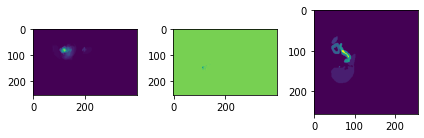

saving directory: all_labels_merged
temp/NAKO/processed_resized/label/100017.nii.gz
256 256 400
temp/NAKO/processed_resized/label/100025.nii.gz
256 256 400
temp/NAKO/processed_resized/label/100112.nii.gz
256 256 400
temp/NAKO/processed_resized/label/100116.nii.gz
256 256 400
temp/NAKO/processed_resized/label/100085.nii.gz
256 256 400
temp/NAKO/processed_resized/label/100009.nii.gz
256 256 400
temp/NAKO/processed_resized/label/100006.nii.gz
256 256 400
temp/NAKO/processed_resized/label/100181.nii.gz
256 256 400
temp/NAKO/processed_resized/label/100129.nii.gz
256 256 400
temp/NAKO/processed_resized/label/100097.nii.gz
256 256 400
temp/NAKO/processed_resized/label/100183.nii.gz
256 256 400
temp/NAKO/processed_resized/label/100094.nii.gz
256 256 400
temp/NAKO/processed_resized/label/100083.nii.gz
256 256 400
temp/NAKO/processed_resized/label/100013.nii.gz
256 256 400
temp/NAKO/processed_resized/label/100020.nii.gz
256 256 400
temp/NAKO/processed_resized/label/100008.nii.gz
256 256 400
temp

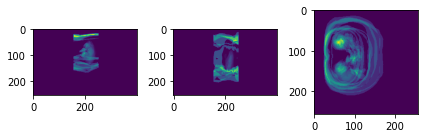

saving directory: all_labels_merged
temp/UKB/processed_resized/label/4627690_20201_2_0.nii.gz
256 256 400
temp/UKB/processed_resized/label/1883132_20201_2_0.nii.gz
256 256 400
temp/UKB/processed_resized/label/3387088_20201_2_0.nii.gz
256 256 400
temp/UKB/processed_resized/label/6025746_20201_2_0.nii.gz
256 256 400
temp/UKB/processed_resized/label/5371767_20201_2_0.nii.gz
256 256 400
temp/UKB/processed_resized/label/1002359_20201_2_0.nii.gz
256 256 400
temp/UKB/processed_resized/label/4154467_20201_2_0.nii.gz
256 256 400
temp/UKB/processed_resized/label/1108214_20201_2_0.nii.gz
256 256 400
temp/UKB/processed_resized/label/1003082_20201_2_0.nii.gz
256 256 400
temp/UKB/processed_resized/label/5331775_20201_2_0.nii.gz
256 256 400
temp/UKB/processed_resized/label/1005379_20201_2_0.nii.gz
256 256 400
temp/UKB/processed_resized/label/1013250_20201_2_0.nii.gz
256 256 400
temp/UKB/processed_resized/label/1026125_20201_2_0.nii.gz
256 256 400
temp/UKB/processed_resized/label/1584559_20201_2_0.nii

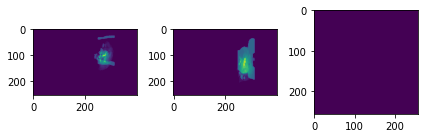

saving directory: all_labels_merged


In [76]:
kls = crop_roi(kora_labels)
volume_3_view_viewer(get_volume_data(kls))
save_volume(kls, f'all_labels_merged/all_kora_labels')

kls = crop_roi(nako_labels)
volume_3_view_viewer(get_volume_data(kls))
save_volume(kls, f'all_labels_merged/all_nako_labels')

kls = crop_roi(ukb_labels)
volume_3_view_viewer(get_volume_data(kls))
save_volume(kls, f'all_labels_merged/all_ukb_labels')

In [80]:
img = nb.load(f'all_labels_merged/all_kora_labels.nii.gz')
img_data = img.get_fdata()
img_d1, s1,e1 = remove_black(img_data)
img_data1 = np.moveaxis(img_data, 1, 0)
img_d2, s2,e2 = remove_black(img_data1)
img_data2 = np.moveaxis(img_data, 2, 0)
img_d3,s3,e3 = remove_black(img_data2)
# img_data = np.moveaxis(img_data, axis=0)

print('kora', img_d1.shape, img_d2.shape, img_d3.shape, s1,e1,s2,e2,s3,e3)

img = nb.load(f'all_labels_merged/all_nako_labels.nii.gz')
img_data = img.get_fdata()
img_d1,s1,e1 = remove_black(img_data)
img_data1 = np.moveaxis(img_data, 1, 0)
img_d2,s2,e2 = remove_black(img_data1)
img_data2 = np.moveaxis(img_data, 2, 0)
img_d3,s3,e3 = remove_black(img_data2)
# img_data = np.moveaxis(img_data, axis=0)

print('nako', img_d1.shape, img_d2.shape, img_d3.shape, s1,e1,s2,e2,s3,e3)

img = nb.load(f'all_labels_merged/all_ukb_labels.nii.gz')
img_data = img.get_fdata()
img_d1,s1,e1 = remove_black(img_data)
img_data1 = np.moveaxis(img_data, 1, 0)
img_d2,s2,e2 = remove_black(img_data1)
img_data2 = np.moveaxis(img_data, 2, 0)
img_d3,s3,e3 = remove_black(img_data2)
# img_data = np.moveaxis(img_data, axis=0)

print('ukb', img_d1.shape, img_d2.shape, img_d3.shape, s1,e1, s2,e2, s3,e3)

kora (224, 256, 400) (133, 256, 400) (179, 256, 256) 0 223 6 138 60 238
nako (208, 256, 400) (149, 256, 400) (96, 256, 256) 7 214 21 169 156 251
ukb (173, 256, 400) (131, 256, 400) (97, 256, 256) 38 210 29 159 217 313


In [ ]:
# KORA = 224,133,179   ---  0 223 6 138 60 238
# NAKO = 208,149,96    --- 7 214 21 169 156 251
# UKB= 173, 131, 97    --- 38 210 29 159 217 313

# KORA sample vol size = 250, 188, 370
# NAKO sample vol size = 226,184,316
# UKB sample vol size = 246, 137, 239
# sample target shape = 256, 256,400

In [ ]:
# file_dict= 
# {
#     VOL_ID: {
#         VOLUME_PATHS: {
#             OPP: [],
#             IN: [],
#             F: [],
#             W: []from nibabel.orientations import axcodes2ornt, ornt_transform, inv_ornt_aff, flip_axis
#         },
#         LABEL_PATHS: [],
#         N4_1: [
#             {
#                 SCALED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled.nii.gz',
#                 IN_BIAS: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_bias_field.nii.gz',
#                 IN_CORRECTED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_corrected.nii.gz',
#                 OPP_CORRECTED: '',
#                 MIN: u_min,
#                 MAX: u_max
#             },
#             {},
#             {}
#         ],from nibabel.orientations import axcodes2ornt, ornt_transform, inv_ornt_aff, flip_axis
#         ONE     : {
#             OPP: '',
#             IN: '',
#             F: '',
#             W: '',
#         },
#         N4_2: {
#             SCALED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled.nii.gz',
#             IN_BIAS: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_bias_field.nii.gz',
#             IN_CORRECTED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_corrected.nii.gz',
#             OPP_CORRECTED: '',
#             MIN: u_min,
#             MAX: u_max
#         },
        
#     }
# }